In [1]:
library(INLA)
library(boot)


Loading required package: Matrix

Loading required package: foreach

Loading required package: parallel

Loading required package: sp

This is INLA_22.05.07 built 2022-05-07 09:52:03 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - To enable PARDISO sparse library; see inla.pardiso()



In [2]:
set.seed(1000)
# set up super simple simulated data.
# 50 patients for each of 4 trial groups. 
n_patients_per_group <- 50
n_groups <- 4
# The group effects are drawn from a distribution with mean 0.5 and variance 1.0
mean_effect <- 0.5
effect_var <- 1.0
t_i <- rnorm(n_groups, mean_effect, sqrt(effect_var))
# inverse logit to get probabilities from linear predictors.
p_i <- inv.logit(t_i)
# simulate
y_i <- rbinom(n_groups, n_patients_per_group, p_i)
sprintf("%.16f", t_i)
sprintf("%.16f", p_i)
sprintf("%.16f", y_i)

[1] "0.0542217351633235"  "-0.7058565689642957" "0.5411263138456900" 
[4] "1.1393884075711429"

[1] "0.5135521136895386" "0.3305150325484877" "0.6320743881220601"
[4] "0.7575673322021476"

[1] "28.0000000000000000" "14.0000000000000000" "33.0000000000000000"
[4] "36.0000000000000000"

In [3]:
# Run INLA with a model where
# logit(p) = intercept + random_effect(drawn iid from normal)
# The prior on the random effect influences the sharing between groups. I
# haven't tuned this yet.
df <- data.frame(y = y_i, gid = (1:n_groups))
result <- inla(
    y ~ f(
        gid, 
        model = "iid",
        hyper = list(theta = list(prior = "gaussian", param = c(0, 0.1)))
    ),
    data = df, 
    Ntrials = rep(n_patients_per_group, n_groups),
    family = "binomial",
    control.compute = list(
        config = TRUE,
        return.marginals.predictor = TRUE
    )
)
summary(result)
# result.samp <- inla.posterior.sample(100, result)
# names(result.samp[[1]])
# print(result.samp[[1]])


Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "numericVector" of class "Mnumeric"; definition not updated”



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " blas.num.threads = blas.num.threads, keep = keep, 


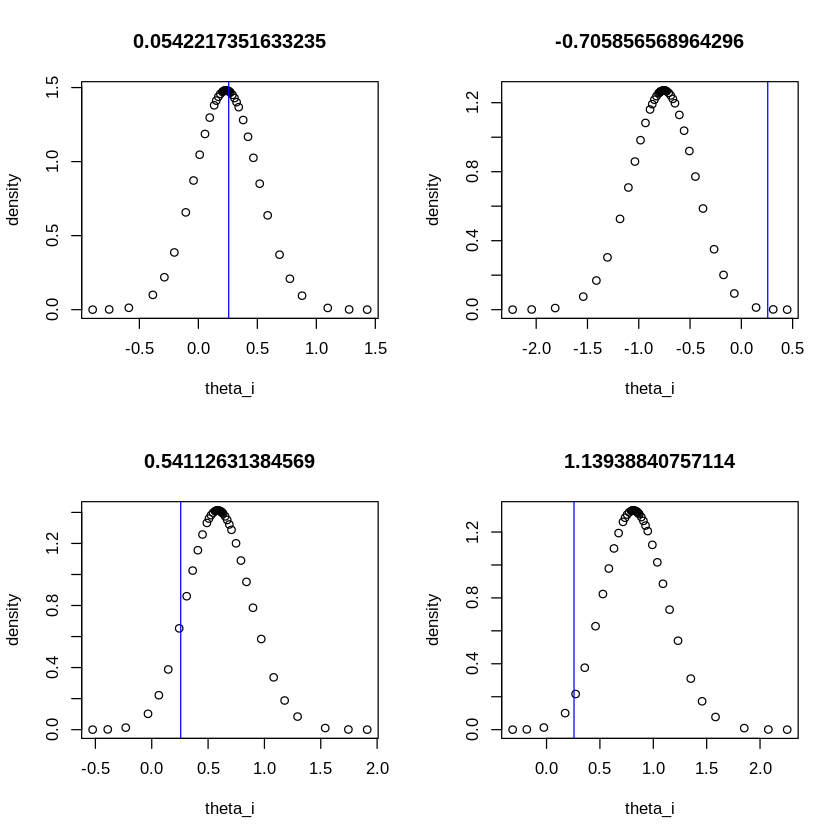

In [4]:
# Plot marginal PDFs.
# These will depend heavily on hyperparameter priors which I have just left
# default for now.
par(mfrow=c(2,2))
for (i in 1:n_groups) {
    theta_i <- result$marginals.linear.predictor[[i]][,1]
    density <- result$marginals.linear.predictor[[i]][,2]
    plot(theta_i, density, main=t_i[[i]])
    abline(v=mean(t_i), col="blue")
}

In [5]:
# Print 95% confidence intervals for the linear predictors. 
# I'm not 100% sure these are correct, but they track correctly with the y_i
for (i in 1:n_groups) {
    print(t_i[[i]])
    print(inla.hpdmarginal(0.95, result$marginals.linear.predictor[[i]]))
}

[1] 0.05422174
                  low      high
level:0.95 -0.2912725 0.7715989
[1] -0.7058566
                 low       high
level:0.95 -1.398296 -0.1607867
[1] 0.5411263
                  low     high
level:0.95 0.05131246 1.165621
[1] 1.139388
                 low     high
level:0.95 0.2552132 1.437339


In [6]:
for (i in 1:n_groups) {
    print(y_i[[i]])
    print(inla.pmarginal(0, result$marginals.linear.predictor[[i]]))
}

[1] 28
[1] 0.1887528
[1] 14
[1] 0.9950012
[1] 33
[1] 0.01385696
[1] 36
[1] 0.001383654
